# Ramp training tutorial for [Google Colab](https://colab.research.google.com/)

This notebook is intended to run you through the ramp training process in the Colab environment, explain what's going on at every stage, and help you understand what's in a training configuration file. 

We'll start by importing python dependencies, including functions needed from the ramp codebase.

In [1]:
%env RAMP_HOME=/content/drive/MyDrive/Omdena/RAMP_HOME

env: RAMP_HOME=/content/drive/MyDrive/Omdena/RAMP_HOME


In [2]:
import os, sys
sys.path.append("..")

# output current working directory.
# Note: the current working directory for this tutorial should be 'colab.'
os.getcwd()

'/content/drive/MyDrive/Omdena/RAMP_HOME/ramp-code/colab'

In [3]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [4]:
import os, sys
from pathlib import Path
import numpy as np
import argparse
import tensorflow as tf
from tensorflow import keras
import datetime
import random
import json
import keras.backend as K
from time import perf_counter

# Note: this suppresses warning and other less urgent messages,
# and only allows errors to be printed.
# Comment this out if you are having mysterious problems, so you can see all messages.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# this variable must be defined. It is the parent of the 'ramp-code' directory.
RAMP_HOME = os.environ["RAMP_HOME"]

# import ramp dependencies.
from ramp.training.augmentation_constructors import get_augmentation_fn 
from ramp.training import callback_constructors
from ramp.training import model_constructors
from ramp.training import optimizer_constructors
from ramp.training import metric_constructors
from ramp.training import loss_constructors

from ramp.data_mgmt.data_generator import training_batches_from_gtiff_dirs, test_batches_from_gtiff_dirs
from ramp.utils.misc_ramp_utils import log_experiment_to_file, get_num_files
from ramp.models.effunet_1 import get_effunet
from ramp.utils.model_utils import get_best_model_value_and_epoch
import ramp.utils.log_fields as lf

import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


### The training configuration file

Training runs are defined using json configuration files, which specify training datasets, training options, and hyperparameter choices. Sample config files are in the 'experiments' subdirectory of the codebase, organized in folders according to the training datasets specified.

At the top level, the config file contains the following blocks:
- *experiment_name*: simple, descriptive name for your own use
- *discard_experiment*: set to 'true' if this is a test run that you don't want to keep any record of
- *logging*: whether to log the experiment to a csv file, and what fields to log
- *datasets*: directories where training and validation datasets are stored
- *num_classes*: 2 for binary masks, 4 for multichannel masks
- *num_epochs*: number of cycles for the training run. Overridden if using early stopping. 
- *batch_size*: number of samples per 'batch'. Smaller batches are needed for smaller gpus. Larger batches stabilize the training metrics, and result in fewer iterations and shorter training times.
- *input_img_shape*: (H,W) of the input images.
- *output_img_shape*: (H,W) of output masks. 
- *loss*: the loss function to use in training, and any parameters to use in its construction.
- *metrics*: the accuracy functions to track during training, and parameters to use in their construction.
- *optimizer*: choice of optimizer to use in training, and optimizer parameters. 
- *model*: choice of model to use in training (currently just EfficientUnet), and parameters to use in its construction, including the variety of EfficientNet to use for the encoder. 
- *saved_model*: whether to resume training from a saved model, and if so, the location of the saved model.  
- *augmentation*: whether to use image augmentation (e.g., random rotations, random changes in color) to regularize training. If so, which augmentations to apply, and parameters needed to construct them. 
- *early_stopping*: whether to use early stopping, and parameters needed to define early stopping rules. 
- *cyclic_learning_scheduler*: whether to use a cyclic learning scheduler (generally no unless you're a power user), and parameters needed to construct one.
- *tensorboard*: whether to log training metrics in tensorboard (always yes), with what frequency, and where to store logs.
- *prediction_logging*: whether to log prediction samples in tensorboard (yes).
- *model_checkpts*: whether to save 'best models' during training (always yes), and to where.
- *random_seed*: an integer to use for the random seed, for reproducibility of results. 



### Read in the configuration file

This code block reads in a sample file. Change this to your own configuration file when you're doing a training run. 

In [5]:
#specify dataset number (1,2,3,4 or 5)
dataset = 2
config_filepath = Path(RAMP_HOME)/f"ramp-code/data/ramp_HOTOSM_config_finetune_{dataset}.json"          #"ramp-code/data/sample_config.json"

with open(str(config_filepath)) as jf:
        cfg = json.load(jf)

# Running the RAMP training code

Now that we know what's in the configuration file, we'll walk through the steps of setting up the training and running it.  


### Step 0: unzip the tiny training data sample.

This example uses an extremely small dataset of 32 training chips and 16 validation chips that is included with the codebase. The first step is to unzip it, if it isn't already unzipped.



In [31]:

#zipfilepath = Path(RAMP_HOME)/"ramp-code/data/HOTOSM.zip"
#target_dir = Path(RAMP_HOME)/"ramp-data/TRAIN"
#from zipfile import ZipFile

#with ZipFile(str(zipfilepath), 'r') as zipObj:
#   zipObj.extractall(path=str(target_dir))





### Step 1: Check your GPU setup and access.

Before you begin training, you'll want to check whether Tensorflow has access to your GPU to run training. The code below helps you diagnose problems.

Below, we directly check Tensorflow access to the GPUs.
You should see as many PhysicalDevice listings as you have GPUs.

In [6]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set up, or disable, logging to Tensorboard and the experiment log. 

Set the timestamp for the current experiment, and add it to the training run configuration.

In [7]:
discard_experiment = False
if "discard_experiment" in cfg:
    discard_experiment = cfg["discard_experiment"]
    
cfg["timestamp"] = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


## Steps 2-5: specifying and compiling the building detection model.

### Step 2: Construct the loss function for the training run.

The user must specify a single loss function for the training run.

To do this, the user specifies a function from the *loss_constructors* module that will be used to construct the loss function. This is necessary because constructing the loss function will frequently require additional parameters to be passed in; for example, a weighted loss function (for example, one that penalizes incorrect boundary pixels more heavily than incorrect background pixels) will need the class weights to be passed in at the time of its construction. These weights must also be defined in the configuration file.

This method of constructing a function dynamically is used repeatedly in the ramp code, as you'll see.

In [8]:

# specify a function that will construct the loss function
get_loss_fn_name = cfg["loss"]["get_loss_fn_name"]
get_loss_fn = getattr(loss_constructors, get_loss_fn_name)
print(f"Loss function constructor: {get_loss_fn.__name__}")

# Construct the loss function 
loss_fn = get_loss_fn(cfg)
print(f"Loss function: {loss_fn.__name__}")


Loss function constructor: get_sparse_categorical_crossentropy_fn
Loss function: sparse_categorical_crossentropy


### Step 3: construct the accuracy metrics for the training run.

While the neural network model uses only one loss function in training, you can specify more than one accuracy metric to track. You should always specify at least one accuracy measure to track. 

As with the loss function, the user must specify the constructor functions that will create the desired accuracy functions. 

In [9]:
the_metrics = []
if cfg["metrics"]["use_metrics"]:

    get_metrics_fn_names = cfg["metrics"]["get_metrics_fn_names"]
    get_metrics_fn_parms = cfg["metrics"]["metrics_fn_parms"]
    
    for get_mf_name, mf_parms in zip(get_metrics_fn_names, get_metrics_fn_parms):
        get_metric_fn = getattr(metric_constructors, get_mf_name)
        print (f"Metric constructor function: {get_metric_fn.__name__}")
        metric_fn = get_metric_fn(mf_parms)
        the_metrics.append(metric_fn)

# Print the list of accuracy metrics
print(f"Accuracy metrics: {[fn.name for fn in the_metrics]}")

Metric constructor function: get_sparse_categorical_accuracy_fn
Accuracy metrics: ['sparse_categorical_accuracy']


### Step 4: construct the optimizer for the training run

Model training proceeds by making incremental adjustments to the model parameters that attempt to minimize (or optimize) the value of the user's chosen loss function. The choice of size and direction for those incremental adjustments is made by an optimization algorithm. 
 
The user must specify the construction function that will construct the optimizer algorithm. In this example, the configuration file also contains a parameter, the 'learning_rate', which is used in the construction of the optimizer. 

In [10]:
#### construct optimizer ####

get_optimizer_fn_name = cfg["optimizer"]["get_optimizer_fn_name"]
get_optimizer_fn = getattr(optimizer_constructors, get_optimizer_fn_name)
print (f"Optimizer constructor: {get_optimizer_fn.__name__}")


optimizer = get_optimizer_fn(cfg)
print(optimizer)
print(float(optimizer.learning_rate))

Optimizer constructor: get_adam_optimizer
0.0003000000142492354


### Step 5: Construct the model.

The code below optionally constructs a new model, or uses a saved model from a previous training run. 

##### use a saved model 

If a saved model is used, the model is loaded from a location in the configuration file. Note that all directories in the configuration file are given relative to the RAMP_HOME environment variable, which must be defined in every environment that runs ramp code. 

If you set *save_optimizer_state* to True in the configuration file, ramp training will proceed using the configuration that was used to train the saved model. This will cause the above specification of loss function, accuracy metrics, and optimizer to be bypassed.

In [11]:
the_model = None

if cfg["saved_model"]["use_saved_model"]:
    
    # load (construct) the model
    model_path = Path(RAMP_HOME) / cfg["saved_model"]["saved_model_path"]
    print(f"Model: importing saved model {str(model_path)}")
    the_model = tf.keras.models.load_model(model_path)
    assert the_model is not None, f"the saved model was not constructed: {model_path}"

    if not cfg["saved_model"]["save_optimizer_state"]:
        # If you don't want to save the original state of training, recompile the model.
        the_model.compile(optimizer = optimizer, 
            loss=loss_fn,
            metrics = [the_metrics])
        
        #the_model.compile(optimizer = optimizer, 
        #    loss=loss_fn,
        #    metrics = [get_iou_coef_fn])

Model: importing saved model /content/drive/MyDrive/Omdena/RAMP_HOME/ramp-code/ramp/checkpoint.tf


##### construct a new model

If a new model is created, the user specifies the constructor for the model. The code below constructs the model, and compiles it (i.e., sets an optimizer, loss function, and metrics).

In [12]:
if not cfg["saved_model"]["use_saved_model"]:
    get_model_fn_name = cfg["model"]["get_model_fn_name"]
    get_model_fn = getattr(model_constructors, get_model_fn_name)
    print(f"Model constructor: {get_model_fn.__name__}")
    the_model = get_model_fn(cfg)

    assert the_model is not None, f"the model was not constructed: {model_path}"
    the_model.compile(optimizer = optimizer, 
        loss=loss_fn,
        metrics = the_metrics)
    
  

print(the_model)

## Steps 6-10: Prepare the training data.

#### Step 6: Specify directories to use for training and validation data. 

The training process uses a training data set, from which it learns the model, and a validation data set, which is used to track how well the trained model performs on data it hasn't been trained with. Both are critical. 

Each data set contains sample image chips and matching truth datasets, stored in geojson files. The base filenames of each matching image and polygon file must match uniquely, e.g., '130bfe-210.tif' and '130bfe-210.geojson'. 

The paths to these datasets are defined in the configuration file, relative to the RAMP_HOME environment variable. 

In [13]:
cfg["datasets"]

{'train_img_dir': 'ramp-data/TRAIN/HOTOSM/2/chips',
 'train_mask_dir': 'ramp-data/TRAIN/HOTOSM/2/binarymasks',
 'val_img_dir': 'ramp-data/TRAIN/HOTOSM/2/val-chips',
 'val_mask_dir': 'ramp-data/TRAIN/HOTOSM/2/val-binarymasks'}

In [14]:
#### define data directories ####
train_img_dir = Path(RAMP_HOME) / cfg["datasets"]["train_img_dir"]
train_mask_dir = Path(RAMP_HOME) / cfg["datasets"]["train_mask_dir"]
val_img_dir = Path(RAMP_HOME) / cfg["datasets"]["val_img_dir"]
val_mask_dir = Path(RAMP_HOME) / cfg["datasets"]["val_mask_dir"]

In [15]:
!ls {train_img_dir} | head -5

OAM-1238424-1046544-21.tif
OAM-1238424-1046545-21.tif
OAM-1238424-1046546-21.tif
OAM-1238424-1046547-21.tif
OAM-1238425-1046544-21.tif


In [16]:
!ls {train_mask_dir} | head -5

OAM-1238424-1046544-21.mask.tif
OAM-1238424-1046545-21.mask.tif
OAM-1238424-1046546-21.mask.tif
OAM-1238424-1046547-21.mask.tif
OAM-1238425-1046544-21.mask.tif


### Step 7: set up the augmentations (i.e., image transformations) that will be applied to the training data.

The *get_augmentation_fn()* constructs a sequence of image transformation functions that will be applied to the training data only (not the validation data). This increases the variability in the data that the model sees during training.

Note that each image transformation function in the list below requires its internal parameters to be set during construction. 

In [17]:
#### get the augmentation transform ####
#aug = None
if cfg["augmentation"]["use_aug"]:
    aug = get_augmentation_fn(cfg)
    print(aug)

Compose([
  Rotate(always_apply=False, p=0.7, limit=(-90, 90), interpolation=0, border_mode=0, value=[0.0, 0.0, 0.0], mask_value=0),
  ColorJitter(always_apply=False, p=0.7, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


### Step 8: Set runtime parameters, and add them to the configuration data.

The number of training iterations per epoch depends on the total quantity of training data chips, and on the batch size. 

The data generator (which 'feeds' data to the model during training) must know the sizes of its input and output images. 

In [18]:
batch_size = cfg["batch_size"]
input_img_shape = cfg["input_img_shape"]
output_img_shape = cfg["output_img_shape"]

n_training = get_num_files(train_img_dir, "*.tif")
n_val = get_num_files(val_img_dir, "*.tif")
steps_per_epoch = n_training // batch_size
validation_steps = n_val // batch_size

# add these back to the config 
# in case they are needed by callbacks
cfg["runtime"] = {}
cfg["runtime"]["n_training"] = n_training
cfg["runtime"]["n_val"] = n_val
cfg["runtime"]["steps_per_epoch"] = steps_per_epoch
cfg["runtime"]["validation_steps"] = validation_steps

### Step 10: set up training and validation data 'feeds'.

Notice the call to construct training batches is different when augmentation is used.

In [19]:
train_batches = None

if aug is not None:
    train_batches = training_batches_from_gtiff_dirs(train_img_dir, 
                                                train_mask_dir, 
                                                batch_size, 
                                                input_img_shape, 
                                                output_img_shape, 
                                                transforms = aug)
else:
    train_batches = training_batches_from_gtiff_dirs(train_img_dir, 
                                                train_mask_dir, 
                                                batch_size, 
                                                input_img_shape, 
                                                output_img_shape)

assert train_batches is not None, "training batches were not constructed"



In [20]:
val_batches = test_batches_from_gtiff_dirs(val_img_dir, 
                                                val_mask_dir, 
                                                batch_size, 
                                                input_img_shape, 
                                                output_img_shape)

assert val_batches is not None, "validation batches were not constructed"

## Steps 11-13: Construct callbacks.

A list of callback functions will be passed to the training process. 

### Step 11: Define all experiment logging and model checkpoint callbacks.

These callbacks are essential and used in every training run (unless it is a throwaway).

#todo: add instructions for starting tensorboard.

In [21]:
callbacks_list = []

if not discard_experiment:

    # get model checkpoint callback
    if cfg["model_checkpts"]["use_model_checkpts"]:
        get_model_checkpt_callback_fn_name = cfg["model_checkpts"]["get_model_checkpt_callback_fn_name"]
        get_model_checkpt_callback_fn = getattr(callback_constructors, get_model_checkpt_callback_fn_name)
        callbacks_list.append(get_model_checkpt_callback_fn(cfg))
        print(f"model checkpoint callback constructor:{get_model_checkpt_callback_fn.__name__}")

    # get tensorboard callback
    if cfg["tensorboard"]["use_tb"]:
        get_tb_callback_fn_name = cfg["tensorboard"]["get_tb_callback_fn_name"]
        get_tb_callback_fn = getattr(callback_constructors, get_tb_callback_fn_name)
        callbacks_list.append(get_tb_callback_fn(cfg))
        print(f"tensorboard callback constructor: {get_tb_callback_fn.__name__}")

    # get tensorboard model prediction logging callback 
    if cfg["prediction_logging"]["use_prediction_logging"]:
        assert cfg["tensorboard"]["use_tb"], 'Tensorboard logging must be turned on to enable prediction logging'
        get_prediction_logging_fn_name = cfg["prediction_logging"]["get_prediction_logging_fn_name"]
        get_prediction_logging_fn = getattr(callback_constructors, get_prediction_logging_fn_name)
        callbacks_list.append(get_prediction_logging_fn(the_model, cfg))
        print(f"prediction logging callback constructor: {get_prediction_logging_fn.__name__}")

# free up RAM
keras.backend.clear_session()


model checkpoint callback constructor:get_model_checkpt_callback_fn
tensorboard callback constructor: get_tb_callback_fn
prediction logging callback constructor: get_pred_logging_callback_fn


### Step 12: Define the early stopping callback if you're using it.

You often will be. 

In [22]:
if cfg["early_stopping"]["use_early_stopping"]:
    print("Using early stopping")
    callbacks_list.append(callback_constructors.get_early_stopping_callback_fn(cfg))

Using early stopping


### Step 13: Define the Cyclic Learning Rate Scheduler callback if you're using it. 

You probably won't need to do this, but it's included here for completeness. 

You'll get an error if you try to use a cyclic learning rate scheduler together with early stopping.

In [23]:
    # get cyclic learning scheduler callback
    if cfg["cyclic_learning_scheduler"]["use_clr"]:
        assert not cfg["early_stopping"]["use_early_stopping"], "cannot use early_stopping with cycling_learning_scheduler"
        get_clr_callback_fn_name = cfg["cyclic_learning_scheduler"]["get_clr_callback_fn_name"]
        get_clr_callback_fn = getattr(callback_constructors, get_clr_callback_fn_name)
        callbacks_list.append(get_clr_callback_fn(cfg))
        print(f"CLR callback constructor: {get_clr_callback_fn.__name__}")

## Step 14: Train the model.

The 'history' return value is a data structure containing training-time information, such as the values of loss and accuracy metrics after every epoch. Most of what it contains is viewable in the Tensorboard application.

The user must specify the number of epochs to run. If early stopping is used, the full number of epochs may not be run. 

In [24]:
n_epochs = cfg["num_epochs"]
print(n_epochs)

10


In [25]:
start = perf_counter()
history = the_model.fit(train_batches, 
        epochs=n_epochs, 
        steps_per_epoch=steps_per_epoch, 
        validation_data=val_batches, 
        validation_steps=validation_steps,
        callbacks=callbacks_list)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.2024 - sparse_categorical_accuracy: 0.8121

6/6 [==============================] - 200s 13s/step - loss: 1.2024 - sparse_categorical_accuracy: 0.8121 - val_loss: 0.6108 - val_sparse_categorical_accuracy: 0.8667
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.5144 - sparse_categorical_accuracy: 0.8576

6/6 [==============================] - 43s 8s/step - loss: 0.5144 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.5347 - val_sparse_categorical_accuracy: 0.8830
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.3935 - sparse_categorical_accuracy: 0.8745

6/6 [==============================] - 41s 8s/step - loss: 0.3935 - sparse_categorical_accuracy: 0.8745 - val_loss: 0.4274 - val_sparse_categorical_accuracy: 0.8998
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.3415 - sparse_categorical_accuracy: 0.8864

6/6 [==============================] - 41s 8s/step - loss: 0.3415 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.3551 - val_sparse_categorical_accuracy: 0.8986
Epoch 5/10
6/6 [==============================] - ETA: 0s - loss: 0.2537 - sparse_categorical_accuracy: 0.9129

6/6 [==============================] - 45s 9s/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9065
Epoch 6/10
6/6 [==============================] - ETA: 0s - loss: 0.2772 - sparse_categorical_accuracy: 0.8838

6/6 [==============================] - 40s 8s/step - loss: 0.2772 - sparse_categorical_accuracy: 0.8838 - val_loss: 0.2697 - val_sparse_categorical_accuracy: 0.9091
Epoch 7/10
6/6 [==============================] - ETA: 0s - loss: 0.2119 - sparse_categorical_accuracy: 0.9160

6/6 [==============================] - 39s 8s/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 0.9205
Epoch 8/10
6/6 [==============================] - ETA: 0s - loss: 0.2055 - sparse_categorical_accuracy: 0.9207

6/6 [==============================] - 40s 8s/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.2003 - val_sparse_categorical_accuracy: 0.9252
Epoch 9/10
6/6 [==============================] - ETA: 0s - loss: 0.2262 - sparse_categorical_accuracy: 0.9191

6/6 [==============================] - 42s 8s/step - loss: 0.2262 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9136
Epoch 10/10
6/6 [==============================] - ETA: 0s - loss: 0.1863 - sparse_categorical_accuracy: 0.9291

6/6 [==============================] - 41s 8s/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9291 - val_loss: 0.2303 - val_sparse_categorical_accuracy: 0.9191


In [26]:
end = perf_counter()
print(f"Time taken to execute code : {end-start} seconds")

Time taken to execute code : 572.8573304040001 seconds


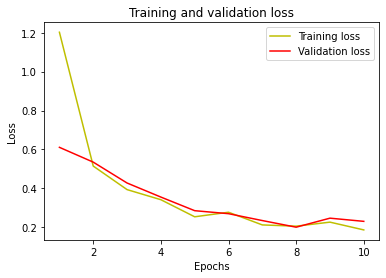

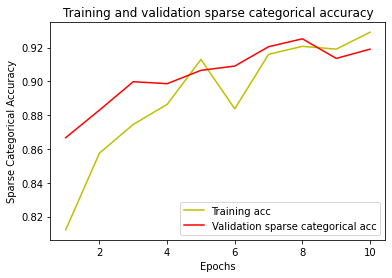

In [27]:
# plot the training and validation accuracy and loss at each epoch
from matplotlib import pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation sparse categorical acc")
plt.title("Training and validation sparse categorical accuracy")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

## Step 15: log experiment information to a central location.

Ramp has a simple mechanism for storing experiment information to a central CSV file, the path to which is specified (like everything else) in the configuration file. Fields to be logged are specified in the 'logging' configuration block, under 'fields_to_log'. 

Fields to be logged should be uniquely named (or you might not get the records you wanted!).

In [28]:
if not discard_experiment and cfg["logging"]["log_experiment"]:
    exp_log_path = str(Path(RAMP_HOME)/cfg["logging"]["experiment_log_path"])
    print(f"logging experiment to: {exp_log_path}")

    # log fields chosen in the configuration file
    # the fields must be uniquely named
    fields_to_log = cfg["logging"]["fields_to_log"]
    exp_log = dict()
    for field_key in fields_to_log:
        field_val = lf.locate_field(cfg, field_key)
        if not isinstance(field_val, dict):
            exp_log[field_key] = field_val
    the_argmax, best_val_acc = get_best_model_value_and_epoch(history)
    exp_log[lf.BEST_MODEL_VALUE] = best_val_acc
    exp_log[lf.BEST_MODEL_EPOCH] = the_argmax
    log_experiment_to_file(exp_log, exp_log_path)

logging experiment to: /content/drive/MyDrive/Omdena/RAMP_HOME/ramp-data/TRAIN/HOTOSM/HOTOSM-experiments.csv
